In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Load and preprocess MPV and income data
To run this notebook, the following files must be in the same directory as the notebook. The last file is not included in the github repo due to size, and must be downloaded separately.
Reported results are for data downloaded on 2020-06-03.
1. https://mappingpoliceviolence.org/ (MPV: MPVDatasetDownload.csv, converted XLSX -> CSV))
2. https://www.ers.usda.gov/data-products/county-level-data-sets/download-data/ 
(Median Income and Unemployment by county: Unemployment.csv)
3. https://www.census.gov/data/tables/time-series/demo/popest/2010s-counties-detail.html 
(Population breakdown by race: cc-est2018-alldata.csv)

## MPV data is directly usable

In [2]:
df_mpv_full = pd.read_csv('MPVDatasetDownload.csv', encoding='unicode_escape').dropna(how='all')
df_mpv_full.head()

,Victim's name,Victim's age,Victim's gender,Victim's race,URL of image of victim,Date of Incident (month/day/year),Street Address of Incident,City,State,Zipcode,...,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65
0,Eric M. Tellez,28,Male,White,https://fatalencounters.org/wp-content/uploads...,12/31/2019,Broad St.,Globe,AZ,85501.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Name withheld by police,NaN,Male,Unknown race,NaN,12/31/2019,7239-7411 I-40,Memphis,AR,38103.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Terry Hudson,57,Male,Black,NaN,12/31/2019,3600 N 24th St,Omaha,NE,68110.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Malik Williams,23,Male,Black,NaN,12/31/2019,30800 14th Avenue South,Federal Way,WA,98003.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Frederick Perkins,37,Male,Black,NaN,12/31/2019,17057 N Outer 40 Rd,Chesterfield,MO,63005.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Median income and unemployment data is also directly usable

In [3]:
''' Pre-processing Median Income and Unemployment data '''
df_med = pd.read_csv('Unemployment.csv', encoding='unicode_escape',
                     usecols=['Stabr', 'area_name', 'Metro_2013', 
                              'Median_Household_Income_2018', 'Unemployment_rate_2018'])
df_med = df_med.set_index('area_name')
df_med = df_med[pd.notnull(df_med['Metro_2013'])] # remove non-county level data

''' Manual corrections to names '''
df_med.index = df_med.index.map(lambda x: x.replace(' County', '')) # remove "County" in county names
df_med.index = df_med.index.map(lambda x: x.replace(' County/city','')) # remove "County/city" in county names
df_med.index = df_med.index.map(lambda x: x.replace('city', 'City')) # capitalize city
df_med.index = df_med.index.map(lambda x: x.replace('/City', '')) # remove county/city ambiguity
df_med.index = df_med.index.map(lambda x: x.replace('/municipality','')) # remove "/municipality" in county names
df_med.index = df_med.index.map(lambda x: x.replace('District of Columbia', 'District of Columbia, DC')) # full name for DC
df_med.index = df_med.index.map(lambda x: x.replace('ñ', 'n')) # simplify special characters
df_med

,Stabr,Metro_2013,Unemployment_rate_2018,Median_Household_Income_2018
area_name,,,,
"Autauga, AL",AL,1.0,3.6,"59,338"
"Baldwin, AL",AL,1.0,3.6,"57,588"
"Barbour, AL",AL,0.0,5.1,"34,382"
"Bibb, AL",AL,1.0,3.9,"46,064"
"Blount, AL",AL,1.0,3.5,"50,412"
...,...,...,...,...
"Vega Baja Municipio, PR",PR,1.0,10.4,NaN
"Vieques Municipio, PR",PR,0.0,16.5,NaN
"Villalba Municipio, PR",PR,1.0,15.8,NaN


## Processing population demographic data

Due to mixed race populations, there is much nuance in defining what it means for a region to be X% black or Y% hispanic. As such, we will be aim to estimate the ratios in size between white:black:hispanic populations rather than the exact breakdown by race. The ratios in the size of these populations is ultimately what will be useful in the statistical analysis. We will consider two approaches for estimating these ratios:
- Method1: "White alone" vs. "Black alone" vs. "Hispanic"
- Method2: "White alone" vs. "Black alone + combination" vs. "Hispanic" 

Note: We will focus only on these three races, as they make up >95% of the data available in MPV dataset.

In [4]:
''' 
Pre-processing population demographic data 
https://www2.census.gov/programs-surveys/popest/technical-documentation/file-layouts/2010-2018/cc-est2018-alldata.pdf
'''
df_pop = pd.read_csv('cc-est2018-alldata.csv', encoding='unicode_escape')
df_pop = df_pop[df_pop['YEAR'] == 11] # focus on most recent 2018-07-01 estimates
df_pop = df_pop[df_pop['AGEGRP'] == 0] # examine demographic data across all age groups
df_pop

,SUMLEV,STATE,COUNTY,STNAME,CTYNAME,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,...,HWAC_MALE,HWAC_FEMALE,HBAC_MALE,HBAC_FEMALE,HIAC_MALE,HIAC_FEMALE,HAAC_MALE,HAAC_FEMALE,HNAC_MALE,HNAC_FEMALE
190,50,1,1,Alabama,Autauga County,11,0,55601,26995,28606,...,738,680,108,102,36,33,19,17,22,12
399,50,1,3,Alabama,Baldwin County,11,0,218022,105657,112365,...,4924,4516,259,253,259,192,69,57,56,34
608,50,1,5,Alabama,Barbour County,11,0,24881,13133,11748,...,472,396,58,49,62,31,1,0,11,8
817,50,1,7,Alabama,Bibb County,11,0,22400,11921,10479,...,286,228,31,16,7,14,1,0,18,3
1026,50,1,9,Alabama,Blount County,11,0,57840,28500,29340,...,2788,2482,79,59,58,65,16,17,32,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655823,50,56,37,Wyoming,Sweetwater County,11,0,43051,22152,20899,...,3379,3055,83,80,201,228,35,42,16,8
656032,50,56,39,Wyoming,Teton County,11,0,23081,11909,11172,...,1674,1560,27,23,104,85,17,13,12,6
656241,50,56,41,Wyoming,Uinta County,11,0,20299,10285,10014,...,857,817,22,22,88,110,5,13,8,3
656450,50,56,43,Wyoming,Washakie County,11,0,7885,3988,3897,...,510,487,10,10,61,60,5,9,5,3


In [5]:
''' Implement state abbreviations '''
df_abb = pd.read_csv('state_abbs.tsv', sep='\t', index_col=0)
state_to_abb = df_abb['Abbreviation'].to_dict()
state_to_abb['District of Columbia'] = 'DC'
df_pop['area_name'] = df_pop['CTYNAME'] + ', ' + df_pop['STNAME'].map(lambda x: state_to_abb[x])

''' Manual corrections to names '''
df_pop.area_name = df_pop.area_name.map(lambda x: x.replace(' County', '')) # remove "County" in county names
df_pop.area_name = df_pop.area_name.map(lambda x: x.replace(' County/city','')) # remove "County/city" in county names
df_pop.area_name = df_pop.area_name.map(lambda x: x.replace('city', 'City')) # capitalize city
df_pop.area_name = df_pop.area_name.map(lambda x: x.replace('/City', '')) # remove county/city ambiguity
df_pop.area_name = df_pop.area_name.map(lambda x: x.replace('ñ', 'n')) # simplify special characters
df_pop.area_name = df_pop.area_name.map(lambda x: x.replace('Anchorage Municipality', 'Anchorage Borough')) # simplify special characters
df_pop.head()

,SUMLEV,STATE,COUNTY,STNAME,CTYNAME,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,...,HWAC_FEMALE,HBAC_MALE,HBAC_FEMALE,HIAC_MALE,HIAC_FEMALE,HAAC_MALE,HAAC_FEMALE,HNAC_MALE,HNAC_FEMALE,area_name
190,50,1,1,Alabama,Autauga County,11,0,55601,26995,28606,...,680,108,102,36,33,19,17,22,12,"Autauga, AL"
399,50,1,3,Alabama,Baldwin County,11,0,218022,105657,112365,...,4516,259,253,259,192,69,57,56,34,"Baldwin, AL"
608,50,1,5,Alabama,Barbour County,11,0,24881,13133,11748,...,396,58,49,62,31,1,0,11,8,"Barbour, AL"
817,50,1,7,Alabama,Bibb County,11,0,22400,11921,10479,...,228,31,16,7,14,1,0,18,3,"Bibb, AL"
1026,50,1,9,Alabama,Blount County,11,0,57840,28500,29340,...,2482,79,59,58,65,16,17,32,23,"Blount, AL"


In [6]:
'''
See above for discussion about computing population ratios between races
df_pop1: White only vs Black only vs Hispanic vs Asian only
df_pop2: White only vs Black+combination vs Hispanic vs Asian+combination

Note: Moving forward, df_pop2 will be used. MPV does not report mixed races, and there
are cases where mixed people are listed as a non-white single-race for consistency.
'''

''' Extract relevant columns '''
df_pop1 = df_pop.loc[:, ['area_name']]
df_pop2 = df_pop.loc[:, ['area_name']]

''' Compute Black and Hispanic population sizes relative to White population size '''
df_pop1['W_TOT'] = df_pop['WA_MALE'] + df_pop['WA_FEMALE']
df_pop1['B_TOT'] = df_pop['BA_MALE'] + df_pop['BA_FEMALE']
df_pop1['H_TOT'] = df_pop['H_MALE'] + df_pop['H_FEMALE']
df_pop1['A_TOT'] = df_pop['AA_MALE'] + df_pop['AA_FEMALE']
df_pop1['B_FRAC'] = df_pop1['B_TOT'] / df_pop1['W_TOT']
df_pop1['H_FRAC'] = df_pop1['H_TOT'] / df_pop1['W_TOT']
df_pop1['A_FRAC'] = df_pop1['A_TOT'] / df_pop1['W_TOT']
df_pop1 = df_pop1.set_index('area_name')

df_pop2['W_TOT'] = df_pop['WA_MALE'] + df_pop['WA_FEMALE']
df_pop2['B_TOT'] = df_pop['BAC_MALE'] + df_pop['BAC_FEMALE']
df_pop2['H_TOT'] = df_pop['H_MALE'] + df_pop['H_FEMALE']
df_pop2['A_TOT'] = df_pop['AAC_MALE'] + df_pop['AAC_FEMALE']
df_pop2['B_FRAC'] = df_pop2['B_TOT'] / df_pop2['W_TOT']
df_pop2['H_FRAC'] = df_pop2['H_TOT'] / df_pop2['W_TOT']
df_pop2['A_FRAC'] = df_pop2['A_TOT'] / df_pop2['W_TOT']
df_pop2 = df_pop2.set_index('area_name')

In [7]:
df_pop1.head()

,W_TOT,B_TOT,H_TOT,A_TOT,B_FRAC,H_FRAC,A_FRAC
area_name,,,,,,,
"Autauga, AL",42660,10915,1649,681,0.255860,0.038654,0.015963
"Baldwin, AL",190301,19492,10131,2508,0.102427,0.053237,0.013179
"Barbour, AL",12209,12042,1064,113,0.986322,0.087149,0.009255
"Bibb, AL",17211,4770,588,53,0.277148,0.034164,0.003079
"Blount, AL",55456,950,5536,185,0.017131,0.099827,0.003336


In [8]:
df_pop2.head()

,W_TOT,B_TOT,H_TOT,A_TOT,B_FRAC,H_FRAC,A_FRAC
area_name,,,,,,,
"Autauga, AL",42660,11463,1649,962,0.268706,0.038654,0.022550
"Baldwin, AL",190301,21123,10131,3404,0.110998,0.053237,0.017887
"Barbour, AL",12209,12264,1064,151,1.004505,0.087149,0.012368
"Bibb, AL",17211,4906,588,85,0.285050,0.034164,0.004939
"Blount, AL",55456,1251,5536,313,0.022558,0.099827,0.005644


# Integrate demographic and MPV data for analysis

In [9]:
''' Reduce to datatypes of interest '''
columns = ["Victim's age", "Victim's gender", "Victim's race", "State", "County", "Date of Incident (month/day/year)",
           "Geography (via Trulia methodology based on zipcode population density: http://jedkolko.com/wp-content/uploads/2015/05/full-ZCTA-urban-suburban-rural-classification.xlsx )"]
df_mpv = df_mpv_full.loc[:,columns]
df_mpv.rename(columns={"Victim's age":'Age', "Victim's gender":'Gender', 
                       "Victim's race": 'Race', "Date of Incident (month/day/year)":'Date',
                      columns[-1]:'Geography'}, inplace=True)
df_mpv.head()

,Age,Gender,Race,State,County,Date,Geography
0,28,Male,White,AZ,Gila,12/31/2019,Rural
1,NaN,Male,Unknown race,AR,Crittenden,12/31/2019,Urban
2,57,Male,Black,NE,Douglas,12/31/2019,Urban
3,23,Male,Black,WA,King,12/31/2019,Suburban
4,37,Male,Black,MO,St. Louis,12/31/2019,Suburban


In [10]:
''' Reduce to cases involving White, Black, or Hispanic victims '''
total_cases = df_mpv.shape[0]
case_races = df_mpv.Race.value_counts(dropna=False)
unknowns = case_races['Unknown race'] + case_races['Unknown Race']
df_mpv = df_mpv[df_mpv['Race'].map(lambda x: x.lower() in ['white','black','hispanic','asian'])]
print('W/B/H/A races:', df_mpv.shape[0], '\t')
print('Other races:', total_cases - unknowns - df_mpv.shape[0])
print('Unknown:', unknowns)
df_mpv.head()

W/B/H/A races: 6775 	
Other races: 154
Unknown: 734


,Age,Gender,Race,State,County,Date,Geography
0,28,Male,White,AZ,Gila,12/31/2019,Rural
2,57,Male,Black,NE,Douglas,12/31/2019,Urban
3,23,Male,Black,WA,King,12/31/2019,Suburban
4,37,Male,Black,MO,St. Louis,12/31/2019,Suburban
5,49,Male,White,WV,Kanawha,12/31/2019,Suburban


In [11]:
demo_data = []
mismatches = 0 
dfp = df_pop2 # switch between df_pop1 and df_pop2

for data in df_mpv.itertuples(name=None):
    state_abb, county = data[4:6]
    if not pd.isnull(state_abb) and not pd.isnull(county):
        location = county + ', ' + state_abb
        
        ''' Make consistent with census data '''        
        location = location.replace('Do¤a', 'Dona')
        location = location.replace('Dekalb', 'DeKalb')
        location = location.replace('Matanuska Susitna', 'Matanuska-Susitna')
        location = location.replace('Athens-Clarke', 'Clarke')
        location = location.replace('Prince Georges', "Prince George's")
        
        ''' Try out alternate spellings '''
        variations = [
            location, 
            location.replace(' City', ''), # try trimming off "City"
            location.replace(' County', ''), # try trimming off "County"
            location.replace(',', ' Parish,'), # try adding "Parish"
            location.replace(',', ' City,'), # try adding "City"
            location.replace(',', ' Borough,'), # try adding "Borough"
            location.replace(',', ' Municipality,') # try adding "Municipality"
        ] 
        
        ''' Try matching MPV location to GDP/POP data '''
        found = False
        for loc in variations:
            if loc in df_med.index and loc in dfp.index:
                median_income = float(df_med.loc[loc, 'Median_Household_Income_2018'].replace(',',''))
                black_ratio = dfp.loc[loc, 'B_FRAC']
                hispanic_ratio = dfp.loc[loc, 'H_FRAC']
                asian_ratio = dfp.loc[loc, 'A_FRAC']
                demo_data.append((median_income, black_ratio, hispanic_ratio, asian_ratio))
                found = True; break
        if not found:
            print('Unmatched:', location)
            demo_data.append((np.nan, np.nan, np.nan, np.nan)); mismatches += 1
            
    else: # skipping cases without documented location
        print('Incomplete location:', state_abb, county)
        demo_data.append((np.nan, np.nan, np.nan, np.nan)); mismatches += 1

initial_cases = df_mpv.shape[0]
df = pd.DataFrame(index=df_mpv.index, data=demo_data, 
                  columns=['County_median_income', 'County_B_FRAC', 'County_H_FRAC', 'County_A_FRAC'])
df_mpv = pd.concat([df_mpv, df], axis=1)
df_mpv = df_mpv[pd.notnull(df_mpv['County_median_income'])]
miss_rate = round(100.0*mismatches/initial_cases, 1)
print('Total cases w/o demographic data:', mismatches, 'of', initial_cases, '\t', str(miss_rate)+'%')
df_mpv.head()

Unmatched: Brooklyn, NY
Unmatched: Manhattan, NY
Unmatched: Webber, UT
Incomplete location: MS nan
Incomplete location: KS nan
Unmatched: Lorrain, OH
Unmatched: LeFlore, OK
Incomplete location: MI nan
Unmatched: Desoto, MS
Unmatched: Saint Louis City, MO
Incomplete location: OR nan
Incomplete location: WI nan
Incomplete location: TN nan
Incomplete location: WA nan
Incomplete location: NC nan
Unmatched: DeBaca, NM
Unmatched: Hendersonville, NC
Unmatched: Rancho Tehama, CA
Unmatched: Yamhill, NM
Unmatched: Clackamus, OR
Unmatched: Acadiana, LA
Incomplete location: IL nan
Unmatched: Le Sueur , MN
Unmatched: Queen Anne, MD
Unmatched: Daviess , KY
Unmatched: Saint Clair, IL
Unmatched: Chavez, NM
Unmatched: Dewitt, IL
Unmatched: Saint Martin, LA
Unmatched: St .Louis, MO
Unmatched: Philadephia, PA
Unmatched: Mohave, WA
Unmatched: Comanche `, OK
Unmatched: Calcasieu , LA
Unmatched: San Bernadino, CA
Unmatched: Chavez, NM
Unmatched: no county (http://www.ask.com/geography/county-newport-news-va

,Age,Gender,Race,State,County,Date,Geography,County_median_income,County_B_FRAC,County_H_FRAC,County_A_FRAC
0,28,Male,White,AZ,Gila,12/31/2019,Rural,43585.0,0.015338,0.238656,0.015551
2,57,Male,Black,NE,Douglas,12/31/2019,Urban,64580.0,0.163032,0.159756,0.061279
3,23,Male,Black,WA,King,12/31/2019,Suburban,94822.0,0.128592,0.146115,0.329181
4,37,Male,Black,MO,St. Louis,12/31/2019,Suburban,66992.0,0.383035,0.043449,0.078027
5,49,Male,White,WV,Kanawha,12/31/2019,Suburban,41926.0,0.104343,0.012542,0.017015


# Computing nation-wide race-specific bias weights

In [12]:
import scipy.optimize 

def compute_weights(df_mpv_sel, non_white={'Black': 'County_B_FRAC', 'Hispanic':'County_H_FRAC'}): #, 'Asian':'County_A_FRAC'}):
    ''' Computes bias terms for victims of police violence being specific non-White races over White '''
    races = ['White'] + list(non_white.keys())
    df = df_mpv_sel[df_mpv_sel['Race'].map(lambda x: x in races)]
    n_cases = df.shape[0]
    
    ''' Compute population ratios specific-race:white within county of incident (i.e. black:white) '''
    df.loc[:,'r_White'] = np.ones(n_cases)
    for race, race_frac_label in non_white.items():
        df.loc[:,'r_' + race] = df[race_frac_label].values
    
    ''' Maximize loglikelihood = MLE for bias terms '''
    def compute_loglikelihood(bias):
        ''' Log-likelihood of observed cases under fixed bias.
            If unbiased, all bias terms are equal to one '''
        loglikelihood = 0.0
        full_bias = np.array([1.0] + list(bias)) # set White bias to 1 (normalizing to White)
        abundance_columns = list(map(lambda x: 'r_' + x, races))
        for r, race in enumerate(races):
            df_race = df[df['Race'] == race] # select cases of the specific race
            race_term = full_bias[r] * df_race['r_' + race] # bias * abundance of race
            bias_tile = np.tile(full_bias, (df_race.shape[0], 1))
            norm_term = np.multiply(bias_tile, df_race[abundance_columns]) # all bias * abundance terms
            norm_term = norm_term.sum(axis=1) # sum all bias * abundance terms to normalize
            loglikelihood += np.sum(np.log(race_term)) - np.sum(np.log(norm_term))
        return loglikelihood
    
    bounds = [(0.0, np.inf)] * (len(races) - 1) # bias value must be positive
    guess = [1.0] * (len(races) - 1) # initialize search with no bias (multipler = 1)
    min_objective = lambda B: -1.0 * compute_loglikelihood(B) # minimize negative loglikelihood = maximize likelihood
    opt = scipy.optimize.minimize(fun=min_objective, x0=guess, bounds=bounds)
    biases = {races[i+1]:opt.x[i] for i in range(len(races) - 1)}
    return df, biases, opt

In [13]:
df, biases_nat, opt = compute_weights(df_mpv,
   non_white={'Black': 'County_B_FRAC', 'Hispanic':'County_H_FRAC', 'Asian':'County_A_FRAC'})

In [14]:
biases_nat

{'Black': 3.4265803510399824,
 'Hispanic': 1.705731011014163,
 'Asian': 0.43831585939660467}

In [15]:
''' From https://colorpalettes.net/color-palette-4213/ '''
bar_colors = {'Black': '#102020', 'Hispanic': '#037c87', 'White': '#a7b5b7', 'Asian': '#abba82'}

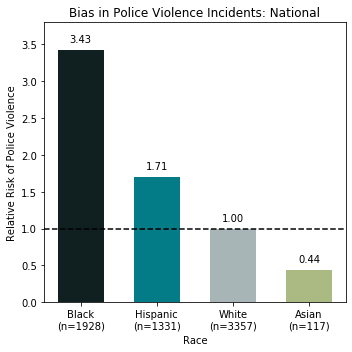

In [16]:
races = ['Black', 'Hispanic', 'White', 'Asian']
race_counts = list(map(lambda r: df_mpv[df_mpv.Race == r].shape[0], races))
race_labels = list(map(lambda x: races[x] + '\n' + '(n=' + str(race_counts[x]) + ')', range(len(races))))
relative_biases = list(map(lambda x: biases_nat[x] if x != 'White' else 1.0, races))
x = [1,2,3,4]

fig, ax = plt.subplots(1,1, figsize=(5,5))
for i, race in enumerate(races):
    plt.bar(x[i], relative_biases[i], width=0.6, color=bar_colors[race])
    plt.text(x[i], relative_biases[i]+0.1, '%.2f' % relative_biases[i], ha='center')
plt.xticks(x, race_labels)
plt.ylim([0.0,3.8])
plt.axhline(1.0, color='k', ls='--')
plt.xlabel('Race')
plt.ylabel('Relative Risk of Police Violence')
plt.title('Bias in Police Violence Incidents: National')
plt.tight_layout()

# Compute bias for income groups

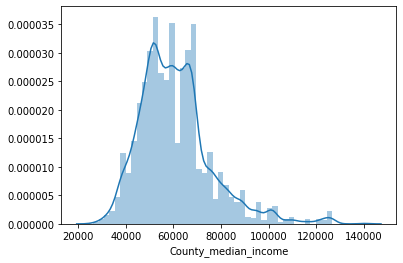

In [17]:
sns.distplot(df_mpv['County_median_income'])

In [18]:
bounds = [0, 45000, 50000, 55000, 60000, 65000, 70000, np.inf]
results_inc = []
for b in range(1,len(bounds)):
    bound = (bounds[b-1], bounds[b])
    df = df_mpv[df_mpv['County_median_income'].map(lambda x: x >= bound[0] and x < bound[1])]
    dfx, biases, opt = compute_weights(df,
       non_white={'Black': 'County_B_FRAC', 'Hispanic':'County_H_FRAC'})
    entry = (bound, df.shape, biases)
    print(entry)
    results_inc.append(entry)

/home/jhyun/.conda/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/jhyun/.conda/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


((0, 45000), (770, 11), {'Black': 1.7564276678171713, 'Hispanic': 1.8133926468355643})
((45000, 50000), (731, 11), {'Black': 2.5336581879119993, 'Hispanic': 1.3400767575201484})
((50000, 55000), (1122, 11), {'Black': 3.4887043769780255, 'Hispanic': 1.6851928639566898})
((55000, 60000), (927, 11), {'Black': 3.2148942271595566, 'Hispanic': 1.1660130896773295})
((60000, 65000), (851, 11), {'Black': 4.421569234763784, 'Hispanic': 1.6058177458429586})
((65000, 70000), (1033, 11), {'Black': 4.571666820326383, 'Hispanic': 2.557543873379613})
((70000, inf), (1299, 11), {'Black': 3.9199725864215824, 'Hispanic': 1.7060776404658589})


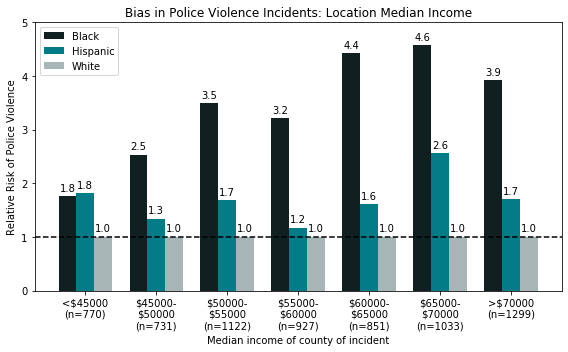

In [19]:
races = ['Black', 'Hispanic', 'White']
fig, ax = plt.subplots(1,1, figsize=(8,5))

''' Generate Bars '''
width = 0.25
for r, race in enumerate(races):
    x = np.arange(1,len(results_inc)+1) + r*width - 0.5*width*(len(races) - 1)
    y = list(map(lambda result: result[-1][race], results_inc)) if race != 'White' else [1.0] * len(results_inc)
    plt.bar(x, y, width=width, label=race, color=bar_colors[race])
    for i in range(len(results_inc)):
        plt.text(x[i], y[i]+0.1, '%.1f' % y[i], ha='center')
plt.axhline(1.0, color='k', ls='--')
plt.legend(loc='upper left')

''' Generate label text '''
labels = list(map(lambda x: '$' + str(x[0][0]) + '-\n$' + str(x[0][1]), results_inc))
labels[0] = '<' + labels[0].split('\n')[-1]
labels[-1] = '>' + labels[-1].split('\n')[0][:-1]
for i, label in enumerate(labels):
    n = results_inc[i][1][0]
    labels[i] = label + '\n(n=' + str(n) + ')'

''' Apply labels '''
plt.ylim([0,5])
plt.xticks(np.arange(1,len(results_inc)+1), labels)
plt.xlabel('Median income of county of incident')
plt.ylabel('Relative Risk of Police Violence')
plt.title('Bias in Police Violence Incidents: Location Median Income')
plt.tight_layout()

# Compute bias by geographic type (Rural/Urban/Suburban)

In [20]:
results_geo = []
for geotype in ['Rural','Suburban','Urban']:
    df = df_mpv[df_mpv['Geography'] == geotype]
    dfx, biases, opt = compute_weights(df,
       non_white={'Black': 'County_B_FRAC', 'Hispanic':'County_H_FRAC'})
    entry = (geotype, df.shape, biases)
    results_geo.append(entry)
    print(entry)

('Rural', (1441, 11), {'Black': 1.5334880569396843, 'Hispanic': 1.2039787186897504})
('Suburban', (3362, 11), {'Black': 2.8840753565533306, 'Hispanic': 1.6044060635081054})
('Urban', (1884, 11), {'Black': 7.0412126632323115, 'Hispanic': 2.6561058688213746})


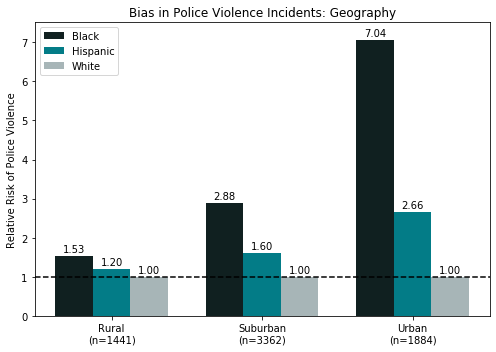

In [22]:
races = ['Black', 'Hispanic', 'White']
fig, ax = plt.subplots(1,1, figsize=(7,5))

''' Generate Bars '''
width = 0.25
for r, race in enumerate(races):
    x = np.arange(1,len(results_geo)+1) + r*width - 0.5*width*(len(races) - 1)
    y = list(map(lambda result: result[-1][race], results_geo)) if race != 'White' else [1.0] * len(results_geo)
    for i in range(len(races)):
        plt.text(x[i], y[i]+0.1, '%.2f' % y[i], ha='center')
    plt.bar(x, y, width=width, label=race, color=bar_colors[race])
plt.axhline(1.0, color='k', ls='--')
plt.legend(loc='upper left')

''' Generate label text '''
labels = list(map(lambda x: x[0], results_geo))
for i, label in enumerate(labels):
    n = results_geo[i][1][0]
    labels[i] = label + '\n(n=' + str(n) + ')'

''' Apply labels '''
plt.ylim([0,7.5])
plt.xticks(np.arange(1,len(results_geo)+1), labels)
plt.ylabel('Relative Risk of Police Violence')
plt.title('Bias in Police Violence Incidents: Geography')
plt.tight_layout()

# Compute bias for age groups

/home/jhyun/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


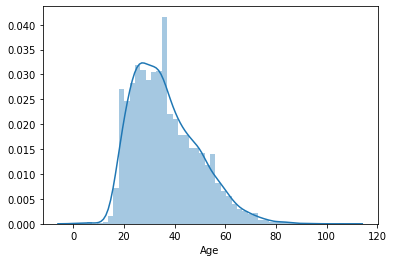

In [23]:
df_mpv_with_ages = df_mpv[df_mpv['Age'].map(lambda x: not x in ['40s', 'Unknown', np.nan])]
df_mpv_with_ages['Age'] = df_mpv_with_ages['Age'].map(int)
sns.distplot(df_mpv_with_ages['Age'])

In [24]:
bounds = [0, 20, 30, 40, 50, 60, np.inf]
results_age = []
for b in range(1,len(bounds)):
    bound = (bounds[b-1], bounds[b])
    df = df_mpv_with_ages[df_mpv_with_ages['Age'].map(lambda x: x >= bound[0] and x < bound[1])]
    dfx, biases, opt = compute_weights(df,
       non_white={'Black': 'County_B_FRAC', 'Hispanic':'County_H_FRAC'})
    entry = (bound, df.shape, biases)
    results_age.append(entry)
    print(entry)

((0, 20), (376, 11), {'Black': 8.536666307077667, 'Hispanic': 3.620786379811757})
((20, 30), (1985, 11), {'Black': 5.982160562281673, 'Hispanic': 2.389294789441573})
((30, 40), (1962, 11), {'Black': 3.657645848245028, 'Hispanic': 1.9221395486733124})
((40, 50), (1232, 11), {'Black': 2.240527563251418, 'Hispanic': 1.245486065487742})
((50, 60), (739, 11), {'Black': 1.0770646583426107, 'Hispanic': 0.8352457050907537})
((60, inf), (362, 11), {'Black': 1.2425939870753226, 'Hispanic': 0.4827744030609363})


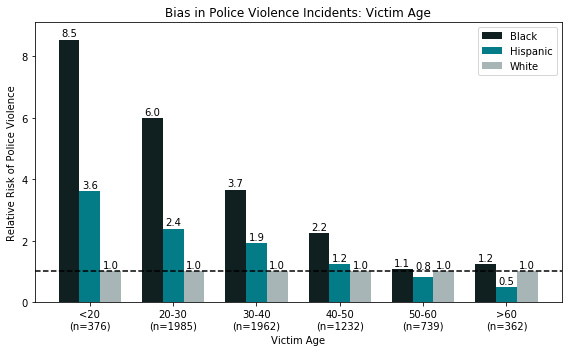

In [25]:
races = ['Black', 'Hispanic', 'White']
fig, ax = plt.subplots(1,1, figsize=(8,5))

''' Generate Bars '''
width = 0.25
for r, race in enumerate(races):
    x = np.arange(1,len(results_age)+1) + r*width - 0.5*width*(len(races) - 1)
    y = list(map(lambda result: result[-1][race], results_age)) if race != 'White' else [1.0] * len(results_age)
    plt.bar(x, y, width=width, label=race, color=bar_colors[race])
    for i in range(len(results_age)):
        shift = 0.1 if y[i] >= 1.0 or y[i] <= 0.5 else 0.25
        plt.text(x[i], y[i]+shift, '%.1f' % y[i], ha='center')
plt.axhline(1.0, color='k', ls='--')
plt.legend(loc='upper right')

''' Generate label text '''
labels = list(map(lambda x: str(x[0][0]) + '-' + str(x[0][1]), results_age))
labels[0] = '<' + labels[0].split('-')[-1]
labels[-1] = '>' + labels[-1].split('-')[0]
for i, label in enumerate(labels):
    n = results_age[i][1][0]
    labels[i] = label + '\n(n=' + str(n) + ')'

''' Apply labels '''
plt.ylim([0,9.1])
plt.xticks(np.arange(1,len(results_age)+1), labels)
plt.xlabel('Victim Age')
plt.ylabel('Relative Risk of Police Violence')
plt.title('Bias in Police Violence Incidents: Victim Age')
plt.tight_layout()